In [16]:
!pip install langchain langchain_community langchain_core langgraph chromadb faiss-cpu sentence_transformers langchain_huggingface

In [48]:
import logging
import os
from google.colab import userdata
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma, FAISS
from langchain.tools.retriever import create_retriever_tool
from langchain_huggingface import HuggingFaceEmbeddings

## Building Tools for Agents

In [54]:
# --- Tool 1: LangGraph Knowledge Base ---
urls = [
    "https://langchain-ai.github.io/langgraph/concepts/why-langgraph/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/graph-api/#map-reduce-and-the-send-api"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splits = text_splitter.split_documents(docs_list)
vectorstore=FAISS.from_documents(documents=doc_splits, embedding=HuggingFaceEmbeddings(model="all-MiniLM-L6-v2"))
retriever = vectorstore.as_retriever()

In [55]:
retriever_tool = create_retriever_tool(
    retriever,
    "retriever_vector_db_blog",
    "Search and retrieve information about LangGraph."
)

In [56]:
retriever_tool

Tool(name='retriever_vector_db_blog', description='Search and retrieve information about LangGraph.', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x794817f63100>, retriever=VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7947ffeb6480>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x794817ef5760>, retriever=VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7947ffeb6480>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), 

In [94]:
# --- Tool 2: LangChain Knowledge Base ---
langchain_urls = [
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]
docs = [WebBaseLoader(url).load() for url in langchain_urls]
docs_list = [item for sublist in docs for item in sublist]
doc_splits = text_splitter.split_documents(docs_list)
vectorstore_langchain = FAISS.from_documents(documents=doc_splits, embedding=HuggingFaceEmbeddings(model="all-MiniLM-L6-v2"))
retriever_langchain = vectorstore_langchain.as_retriever()

In [95]:
retriever_tool_langchain = create_retriever_tool(
    retriever_langchain,
    "retriever_vector_langchain_blog",
    "Search and retrieve information about the general LangChain framework."
)

In [96]:
retriever_tool_langchain

Tool(name='retriever_vector_langchain_blog', description='Search and retrieve information about the general LangChain framework.', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x794817f63100>, retriever=VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7947d805db80>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x794817ef5760>, retriever=VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7947d805db80>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={},

In [97]:
tools = [retriever_tool, retriever_tool_langchain]

In [98]:
tools

[Tool(name='retriever_vector_db_blog', description='Search and retrieve information about LangGraph.', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x794817f63100>, retriever=VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7947ffeb6480>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x794817ef5760>, retriever=VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7947ffeb6480>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'),

## Defining the Agent's State and Workflow with LangGraph

In [99]:

from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [100]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [101]:
!pip install -q langchain-groq

In [102]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="moonshotai/kimi-k2-instruct")
llm_with_tools = llm.bind_tools(tools)

In [103]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7947d805e8a0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7947d7f69760>, model_name='moonshotai/kimi-k2-instruct', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'retriever_vector_db_blog', 'description': 'Search and retrieve information about LangGraph.', 'parameters': {'properties': {'query': {'description': 'query to look up in retriever', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'retriever_vector_langchain_blog', 'description': 'Search and retrieve information about the general LangChain framework.', 'parameters': {'properties': {'query': {'description': 'query to look up in retriever', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

Now we define the nodes and edges for our self-corrective graph. This workflow is more advanced than a simple tool-calling agent. It includes nodes for retrieving, grading the relevance of the retrieval, and rewriting the query if needed.

In [104]:
from langchain_core.messages import SystemMessage, ToolMessage, HumanMessage

In [105]:
# --- AGENT NODE ---
def agent(state: AgentState):
    print("--- CALL AGENT ---")
    system_prompt = """You are a helpful assistant. Your main purpose is to answer questions about LangChain and LangGraph.
    You have access to two specific tools to answer questions about these topics. Based on the user's query, you must decide which, if any, tool to call."""

    messages = [SystemMessage(content=system_prompt)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [106]:
from typing import Literal
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field

In [107]:
# --- GRADER NODE ---
# This node evaluates the relevance of the retrieved documents.
def grade_documents(state) -> Literal["generate", "rewrite"]:
    print("--- CHECK DOCUMENT RELEVANCE ---")

    class Grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # Use a separate, structured-output LLM for grading.
    grader_llm = ChatGroq(model="deepseek-r1-distill-llama-70b").with_structured_output(Grade)

    prompt = PromptTemplate(
        template="""You are a grader assessing the relevance of a retrieved document to a user question.
        Here is the retrieved document: \n\n {context} \n\n Here is the user question: {question} \n

        If the document contains keywords or semantic meaning related to the question, grade it as relevant.
        Give a binary score 'yes' or 'no' to indicate whether the document is relevant.""",
        input_variables=["context", "question"],
    )

    chain = prompt | grader_llm
    question = state["messages"][0].content
    docs = state["messages"][-1].content

    # Invoke the chain to get the grade.
    scored_result = chain.invoke({"question": question, "context": docs})

    if scored_result.binary_score == "yes":
        print("--- DECISION: DOCS RELEVANT ---")
        return "generate" # If relevant, proceed to generate the answer.
    else:
        print("--- DECISION: DOCS NOT RELEVANT ---")
        return "rewrite" # If not relevant, go to the rewrite node.

In [108]:
# --- GENERATE NODE ---
# This node generates the final answer if the documents are deemed relevant.
def generate(state: AgentState):
    print("--- GENERATE FINAL ANSWER ---")
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = f"""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
    If you don't know the answer, just say that you don't know. Keep the answer concise.
    Question: {question} \n Context: {context} \n Answer:"""

    response = llm.invoke(prompt)
    return {"messages": [response]}

In [109]:
# --- REWRITE NODE ---
# This node rewrites the user's question if the initial retrieval was not relevant.
def rewrite(state):
    print("--- REWRITING QUERY ---")
    question = state["messages"][0].content

    msg = [HumanMessage(content=f"""Look at the input and reason about the underlying semantic intent.
    Formulate an improved question based on the initial question: {question}""")]

    response = llm.invoke(msg)
    return {"messages": [response]}

## Constructing the Self-Corrective Graph

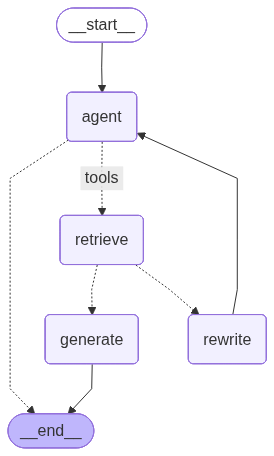

In [110]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

workflow = StateGraph(AgentState)

# Add all the nodes to the graph.
workflow.add_node("agent", agent)
workflow.add_node("retrieve", ToolNode(tools))
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

# Define the edges and the overall flow.
workflow.add_edge(START, "agent")

# Conditional edge from the agent: either call a tool or end.
workflow.add_conditional_edges(
    "agent",
    lambda state: "tools" if state['messages'][-1].tool_calls else END,
    {"tools": "retrieve", END: END}
)

# Conditional edge from the retrieve node: grade documents.
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    # If docs are relevant, generate. If not, rewrite the query and loop back to the agent.
    {"generate": "generate", "rewrite": "rewrite"}
)

# Final edges: after generating an answer, end. After rewriting, go back to the agent.
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile the graph.
graph = workflow.compile()

# Visualize the graph.
graph

In [111]:
# Invoke the graph with a question about doc.
# The agent should call the correct tool, get relevant docs, and generate an answer.
result = graph.invoke({"messages": [HumanMessage(content="What is Machine Learning?")]})

--- CALL AGENT ---


In [112]:
ai_content = result["messages"][-1].content
print(ai_content)

Machine Learning (ML) is a sub-field of artificial intelligence that focuses on algorithms and statistical models which enable computers to perform a task without being explicitly programmed for every rule. Instead, the system learns patterns from data and uses those patterns to make predictions or decisions on new, unseen data.

Key ideas:

1. Data-driven: ML systems improve automatically as they are exposed to more examples.
2. Generalization: After learning from training data, the model should perform well on data it has never seen.
3. Types of learning:
   - Supervised learning: The model learns from labeled examples (input-output pairs). Common tasks are classification and regression.
   - Unsupervised learning: The model finds hidden structure in unlabeled data (e.g., clustering, dimensionality reduction).
   - Reinforcement learning: An agent learns by interacting with an environment, receiving feedback in the form of rewards or penalties.
4. Typical workflow: collect data → pre

In [113]:
result = graph.invoke({"messages": [HumanMessage(content="What is LangGraph?")]})

--- CALL AGENT ---
--- CHECK DOCUMENT RELEVANCE ---
--- DECISION: DOCS RELEVANT ---
--- GENERATE FINAL ANSWER ---


In [114]:
ai_content = result["messages"][-1].content
print(ai_content)

LangGraph is a library (built by LangChain) for orchestrating multi-step, stateful LLM applications. It lets you define a graph of nodes (steps) and edges (transitions), automatically checkpointing state between steps so you can pause, resume, rewind, or add human-in-the-loop controls while also providing tools for debugging and visualization.


In [115]:
result = graph.invoke({"messages": [HumanMessage(content="tell me about Langchain")]})

--- CALL AGENT ---
--- CHECK DOCUMENT RELEVANCE ---
--- DECISION: DOCS RELEVANT ---
--- GENERATE FINAL ANSWER ---


In [116]:
ai_content = result["messages"][-1].content
print(ai_content)

LangChain is an open-source framework that helps developers build applications using large language models (LLMs). It provides modular components for chat models, vector stores, retrievers, tools, and more, and supports features like retrieval-augmented generation (RAG), streaming, and structured outputs. It also includes an ecosystem of tools like LangSmith and LangGraph for monitoring and orchestration.


## Key Takeaways
1. **Agentic RAG is Dynamic:** Unlike linear RAG pipelines, Agentic RAG uses an LLM-powered agent to dynamically decide what actions to take, such as choosing the right tool for a given query.

2. **Tools are the Agent's Actions:** The core of an Agentic RAG system is giving the agent a set of tools. The create_retriever_tool function is a simple way to wrap any data retriever into a tool the agent can use.

3. **LangGraph for Cyclical Workflows:** LangGraph is the key library for building agentic systems. It allows you to define your workflow as a state graph with nodes (actions) and conditional edges (logic), enabling loops and complex decision-making.

4. **Self-Correction for Robustness:** This advanced workflow shows a self-corrective pattern. By adding nodes to grade the relevance of retrieved documents and rewrite the query if needed, the agent can recover from a poor initial retrieval, making the system much more robust.

5. **State Management:** The AgentState object acts as the agent's memory, persisting information across the different nodes and cycles of the graph.